# grid world
This is a simple gridworld implementation built in [openai gym](https://gym.openai.com/). The agent (☺) can move left, right, up, and down in user-defined mazes. A `nonterminal_reward` (-1 by default) is emited every step until one of the `terminal_states` is reached, each of which is associated with a user-defined reward. Actions that would move the agent into a wall have no effect on the state, but still cause the `non-terminal reward` to be emitted.

Mazes can be created from scratch or loaded from`rickgrid.mazes`. To create from scratch:

In [1]:
import gym
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
from rickgrid.mazes import mazes
from rickgrid import Agents

%load_ext autoreload
%autoreload 2
np.random.seed(0)

In [2]:

# make a simple maze
env = gym.make('RickGrid-v0',
               walls = np.array([[0,1,0,0,0],
                                 [0,1,1,1,0],
                                 [0,0,0,0,0],
                                 [1,1,1,1,0],
                                 [0,0,0,0,0]], dtype='bool'),
               terminal_states = [[4,0,1], [0,2,10]],   # each terminal state has [row, col, reward]
               start_coords = [0,0],                    # where the agent starts
               nonterminal_reward=-1)                   # -1 reward per non-terminal step

The environment behaves like other environments in openai gym. We can take actions visualize the result as follows:

In [3]:
env.render(); # show maze
env.step(1);  # step to the right
env.render(); # show maze again


██████████████
██☺ ██10    ██
██  ██████  ██
██          ██
██████████  ██
██ 1        ██
██████████████

██████████████
██☺ ██10    ██
██  ██████  ██
██          ██
██████████  ██
██ 1        ██
██████████████


# control methods

To 'solve' these mazes, I've implmented Q-Learning, Monte Carlo, [Exact Dynamic Programming](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf), and Dynamic Programming (as described by [Sutton and Barto](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)). I will test these methods out on this simple default maze:

In [4]:
env = mazes['basic']
env.render();


██████████████
██☺   ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████


## q-learning

We can learn policies using action-value based tabular methods. In this [Q-Learning implementation](), the agent acts $\epsilon$-greedy with respect to the estimated return for each state-action pair, $\hat{q}(s,a)$. These estimates are updated online (after each step) according to

$$\hat{q}(s,a) \leftarrow \hat{q}(s,a) + \alpha [R_t + \gamma \max_{a}\hat{q}(S_{t+1},a) - \hat{q}(s,a)]$$

where $\gamma$ is a discount factor ($\gamma=1$ in this notebook) and $\alpha$ is the learning rate.

Let's train a Q agent!



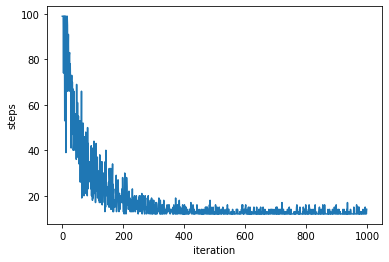

In [5]:
agent = Agents.QLearning(env)
steps, reward = agent.train(
    iterations=1000,
    max_steps=100,        # max steps per episode
    epsilon=.05,
    alpha=.05,
    gamma=1,
    online_update=True)   # update q on every step

ax = plt.axes(xlabel='iteration', ylabel='steps')
ax.plot(steps);

We can can check the resultant policy and $\hat{q}(s,a)$ as follows:


██████████████
██▿ ▿ ██ ▹☺ ██
██▿ ▿ ██ ▹▵ ██
██▿ ▿ ██ ▹▵ ██
██ ▹▿ ██ ▹▵ ██
██ ▹ ▹ ▹▵ ▵ ██
██████████████


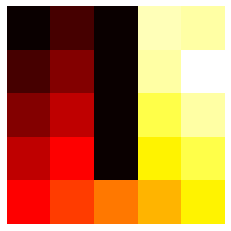

In [6]:
agent.show_policy()
agent.show_q()

## monte carlo

We can also learn $\hat{q}(s,a)$ using a [Monte Carlo method](). Again the agent acts $\epsilon$-greedy, but the expected return for each state-action pair is approximated using an exponentially weighted emperical average. This average is computed incrementally as follows:

$$\hat{q}(s,a) \leftarrow \hat{q}(s,a) + \alpha [G_t - \hat{q}(s,a)]$$

where $G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} \dots \gamma^{T-t} R_T$ and $T$ is the number of time steps in the episode.

Let's train a Monte Carlo agent!



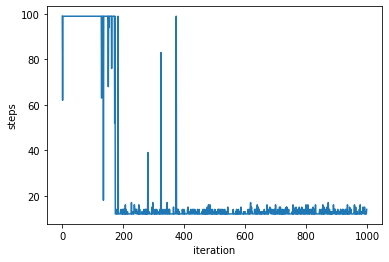

In [7]:
agent = Agents.MonteCarlo(env)
steps, reward = agent.train(
    iterations=1000,
    max_steps=100,
    epsilon=.05,
    alpha=.05,
    gamma=1)

ax = plt.axes(xlabel='iteration', ylabel='steps')
ax.plot(steps);

The learning curve is a little goofy. There seems to be an 'aha' moment. The agent has to accidentally discover the terminal location at least once before learning can really occur. This could be problematic for larger state spaces (see below).

## (approximate) dynamic programming

The following approach is referred to in [Sutton and Barto as 'dynamic programming'](http://incompleteideas.net/book/the-book-2nd.html), and by [Dimitri Bertsekas as 'approximate dynamic programming'](https://web.mit.edu/dimitrib/www/RL_1-SHORT-INTERNET-POSTED.pdf). It falls within the 'generalized policy iteration' framework, wherein we iterate between approximating the value function for the current policy (evaluation) and improving the policy based on the value function (improvement).

To evaluate the action-value function for the curent policy we loop across state-action pairs and use the Bellman-like update rule

$$ \hat{q}_\pi(s,a) \leftarrow \hat{q}_\pi(s,a) + \alpha (R_{t+1} + \gamma \hat{q}_\pi(S_{t+1},A_{t+1}) - \hat{q}_\pi(s,a))$$

where $A_{t+1}$ is chosen according to the policy under evaluation. In the following code we update $\hat{q}_\pi(s,a)$ `eval_iterations` times before updating the $\epsilon$-greedy policy according to the new value function.

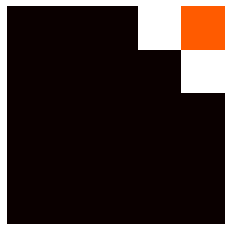

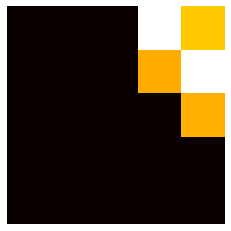

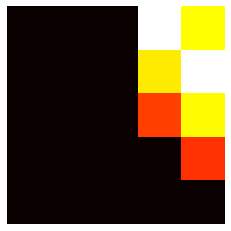

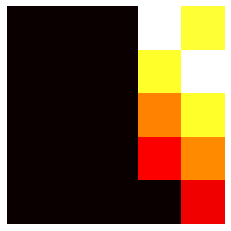

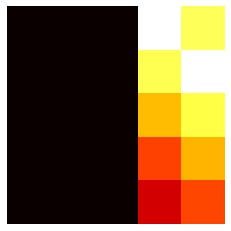

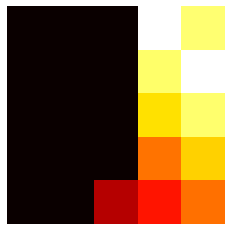

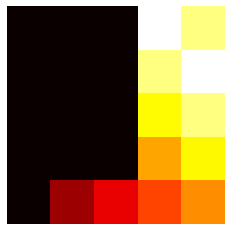

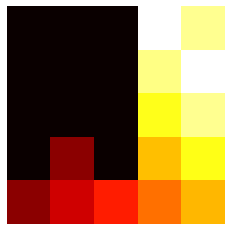

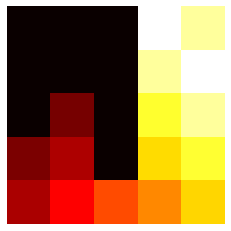

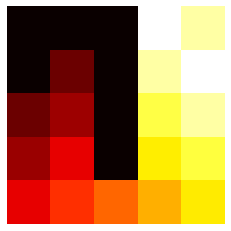

In [25]:
agent = Agents.DP_approx(env)

for i in range(10):
    agent.evaluate_and_update(eval_iterations=100)
    agent.show_q()

## (exact) dynamic programming

todo


██████████████
██▿  ▹██▵ ☺ ██
██▵ ▿ ██ ▹▵ ██
██ ◃▿ ██ ◃ ◃██
██▵  ▹██▵ ▵ ██
██▵ ▿ ▿  ◃▿ ██
██████████████

██████████████
██ ▹▿ ██ ▹☺ ██
██▿ ▿ ██ ▹▵ ██
██▿ ▿ ██ ▹▵ ██
██ ▹▿ ██▵ ▵ ██
██ ▹ ▹ ▹▵ ▵ ██
██████████████
